In [1]:
import scanpy as sc
import pandas as pd
import statistics

In [2]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sc.settings.n_jobs=2

In [3]:
bdata = sc.read_csv('GSM1599494_ES_d0_main.csv') #Change this name to the data you want to read

In [4]:
bdata.obs_names_make_unique()

In [5]:
bdata = bdata.transpose() #Run this if necessary; we want genes as columns and cells as rows

In [6]:
bdata.var['mt'] = bdata.var_names.str.startswith('Mt') #Mitochondrial genes
sc.pp.calculate_qc_metrics(bdata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True) #Calculate metrics

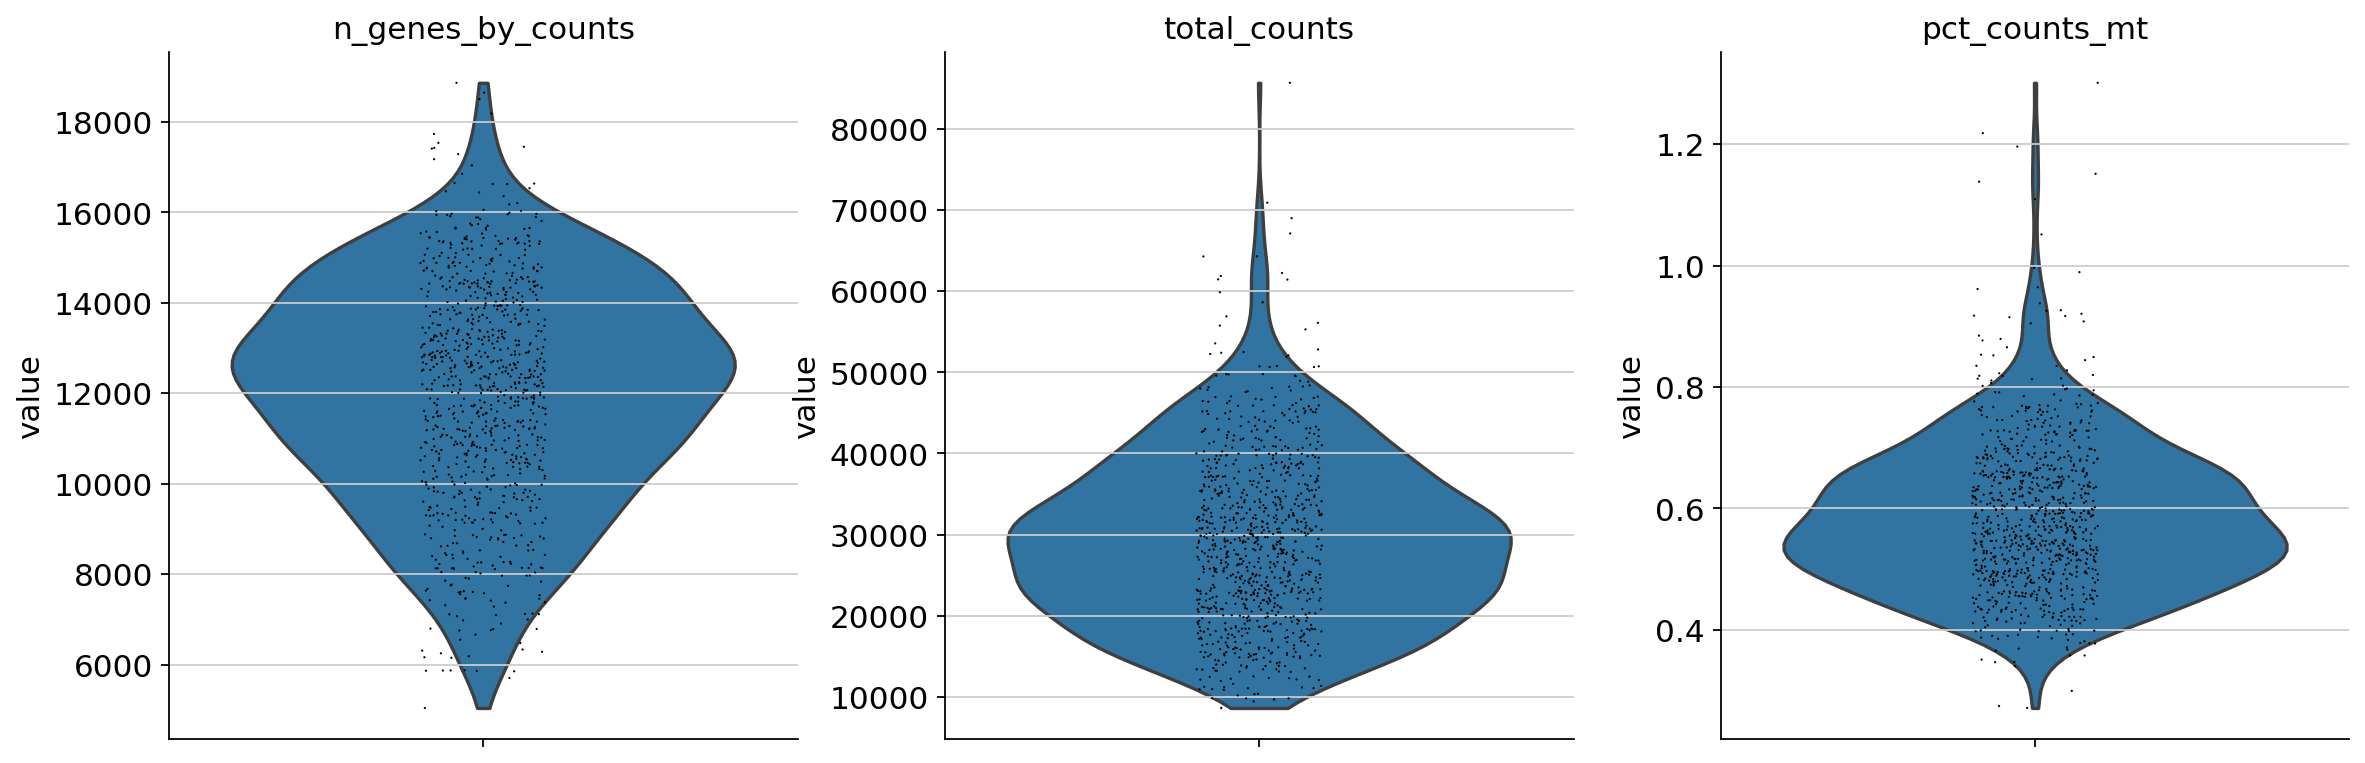

In [7]:
sc.pl.violin( #Plot some violin plots for mitochondrial genes
    bdata, 
    [
     'n_genes_by_counts', 
     'total_counts', 
     'pct_counts_mt'
     ],
    multi_panel=True
)

In [8]:
bdata = bdata[bdata.obs['pct_counts_mt'] < 5, :] #Filter out genes with high mitochondrial read percentages

In [9]:
#RUN THIS CELL ONLY IF YOU WANT CPM NORMALIZATION
bdata.layers["counts"] = bdata.X.copy()
df = bdata.to_df()
sc.pp.normalize_total(bdata, target_sum=1000000) #CPM
sc.pp.log1p(bdata) #log(expression + 1)
bdata.raw = bdata

In [9]:
#RUN THIS CELL ONLY IF YOU WANT TOTAL COUNT NORMALIZATION
bdata.layers["counts"] = bdata.X.copy()
df = bdata.to_df()
avgcellcount = 0
for i in range(df.shape[0]):
    cellcounts = df.iloc[i]
    avgcellcount += statistics.mean(cellcounts) #Find average read count across all cells
cellcountsums = []
for i in range(df.shape[0]):
    cellcounts = df.iloc[i]
    cellcountsums.append(round(statistics.mean(cellcounts) * df.shape[0])) #List of total read counts per cell
for i in range(df.shape[0]):
    print(i)
    for j in range(len(df.iloc[i])):
        df.iloc[i][j] = (df.iloc[i][j] * avgcellcount)/cellcountsums[i] #Multiply each gene read by average read count across all cells
        #Then divide by total read count for that cell
bdata = sc.AnnData(df)
print(bdata.X)
print(bdata.X)
bdata.raw = bdata

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [10]:
coefficientsofvariation = []
means = []
stdevs = []
for i in range(df.shape[1]):
    counts = df.iloc[:,i]
    mean = statistics.mean(counts) #Calculate mean counts for each gene
    means.append(mean)
    stdev = statistics.stdev(counts) #Calculate stdev for each gene
    stdevs.append(stdev)
    if (not(mean == 0)):
        coefficientsofvariation.append(stdev/mean) #Calculate coefficient of variation, provided mean count for that gene is nonzero
    else:
        coefficientsofvariation.append(-1) #Use -1 for coefficient of variation if mean count is zero

In [11]:
print(coefficientsofvariation)

[1.441239267003371, 1.222193416493578, 1.4772785279053595, 1.8997455146477333, 0.9667412595447021, 2.1004970040814888, 1.1938280214667059, 0.8899437461844413, 1.565867041257619, 1.059052747968396, 0.9954201665878, 1.1199095360374256, 1.9535453179769293, 1.164389052261508, 2.228678685465492, 1.570100806339007, 1.8429950672869109, 0.9700291555305358, 1.3588544536030143, 1.5870044801584384, 1.3110242978182423, 1.5015972378626945, 1.0321733894225642, 1.304621004237569, 0.8994889620918073, 1.6695737661926633, 1.514964421685774, 0.7998167200314796, 1.0580984249653735, 1.1756453274547953, 1.5230978039994763, 1.2707407816442728, 1.7056040506538737, 1.6080595307918084, 1.0288641656993365, 1.8066936961858886, 1.2303325477324363, 1.6175831008826713, 1.3116516546860961, 1.4966781226259063, 1.5162696116293377, 0.5572708140477153, 0.881061544669066, 0.8984282452352848, 1.1219541614121957, 1.6580938250334316, 1.0214646066332393, 1.7768338586928962, 0.8384835431737684, 1.5734336318826672, 1.2981722544

In [12]:
vscores = []
for i in range(len(coefficientsofvariation)):
    if coefficientsofvariation[i] == -1:
        vscores.append(-1) #Use -1 for vscore if mean count for that gene is 0
    else:
        CVmhat = coefficientsofvariation[i]
        vscores.append(CVmhat**2/((1.174784/means[i])+0.04)) #Replace 0.36, 0.2 with appropriate CV_M, CV_(1/N) values

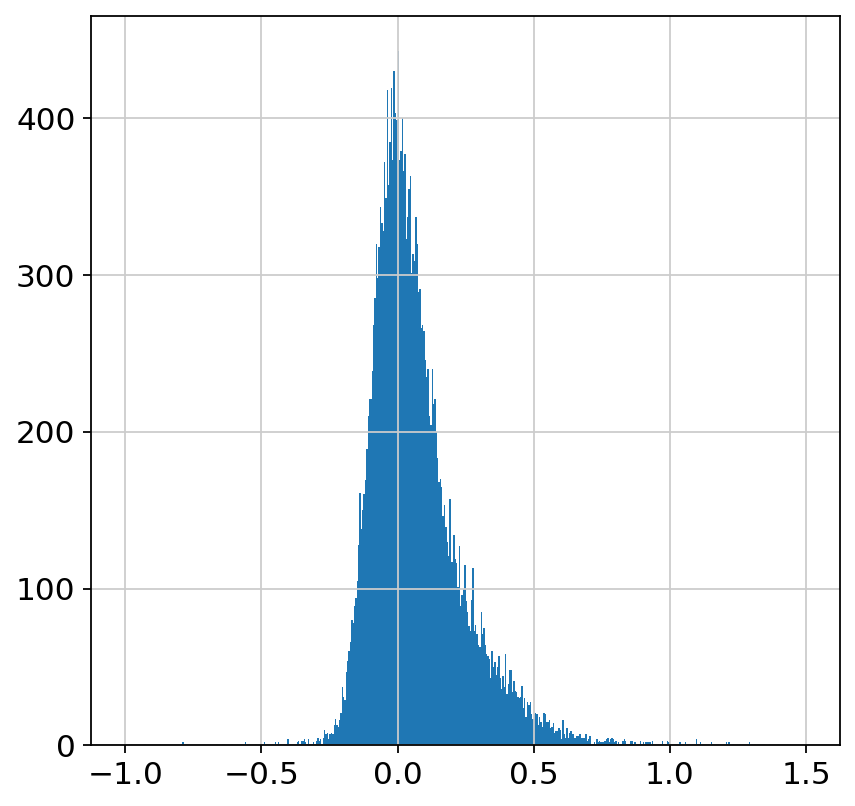

In [13]:
import math
import matplotlib.pyplot as plt
vscoreslog2 = [math.log2(i) for i in vscores if (not i == -1)]
plt.hist(vscoreslog2, bins = 500, range = [-1,1.5])
plt.show()

In [14]:
hvg = 0
i = 0
for score in vscores:
    if score >= 1.2: #Find number of highly variable genes, change threshold as needed (1.186 is the threshold used in Klein paper)
        hvg += 1
print(hvg)

2987


In [15]:
df2 = pd.read_csv('mmc3.csv')

In [16]:
#This cell matches the highly variable genes found by this code to the relevant genes in Klein et al.
genes = df2['Gene symbol'].tolist()
genesall = list(df)
minvscore = 30
nummatches = 0
for j in range(len(genes)):
    for i in range(len(genesall)):
        if genes[j] == genesall[i]:
            print(vscores[i])
            if vscores[i] < minvscore:
                minvscore = vscores[i]
            if vscores[i] >= 1.2:
                nummatches += 1
            break
print(minvscore)
print(nummatches)

22.09124163072185
19.68002441125889
14.963347452904934
14.911007566708244
12.477613812205737
9.974364728366554
7.578872340365079
8.705409811695038
6.796202178356424
7.459995714366212
6.39780366172978
5.833325356301552
4.957829431661211
4.678517539287209
4.71253292993747
4.480266187129186
4.2030704092162035
3.8078876740704177
4.072354150317048
3.5969760740033507
3.447394966175347
3.3261259275511628
3.1677180179558393
3.051970730459911
3.099321816051442
3.0509659956099826
3.0982549026625255
3.0503953601658114
2.979045163801063
2.9305226063466883
2.9865072889646584
2.9056104540807746
3.3524842421762155
2.8250088710714176
2.7144604599393056
2.8407157781958277
2.6973405260163137
3.106301386051895
2.5810041061930757
2.534465754043468
2.4974335869935516
2.446569922365953
2.540993516410654
2.5060213884555673
2.52603184448576
2.3867159811500516
2.446416174384667
2.3716015206287158
2.5176585299438607
2.3214338035917015
2.3064676711368457
2.4637159786245992
2.2808638208682526
2.306382471446274
2.

In [17]:
for i in range(len(genesall)):
    if vscores[i] >= 1.2:
        print(genesall[i])

0610007P14Rik
0610038B21Rik
1110001J03Rik
1110004F10Rik
1110007C09Rik
1110008F13Rik
1110008P14Rik
1110038B12Rik
1110038F14Rik
1110058L19Rik
1110065P20Rik
1190005I06Rik
1500011K16Rik
1500012F01Rik
1700007K13Rik
1700010I02Rik
1700021F05Rik
1700024P16Rik
1700025M24Rik
1700028B04Rik
1700034E13Rik
1700037H04Rik
1700044C05Rik
1700126H18Rik
1810009A15Rik
1810022K09Rik
1810037I17Rik
2010107E04Rik
2200002D01Rik
2310009B15Rik
2310011J03Rik
2310036O22Rik
2410003L11Rik
2410004N09Rik
2410006H16Rik
2410015M20Rik
2410016O06Rik
2500004C02Rik
2510039O18Rik
2610507B11Rik
2700046A07Rik
2700060E02Rik
2700094K13Rik
2810004N23Rik
2810008D09Rik
2810403A07Rik
2810428I15Rik
3110001I22Rik
3110040N11Rik
3110052M02Rik
3110062M04Rik
4833439L19Rik
4921534H16Rik
4930444M15Rik
4930520O04Rik
4930579F01Rik
4933402N03Rik
4933403O08Rik
4933408B17Rik
4933440J02Rik
5430434I15Rik
5730508B09Rik
6030408B16Rik
6430573F11Rik
6430706D22Rik
9330111N05Rik
9330175M20Rik
A130077B15Rik
A430005L14Rik
A430078G23Rik
A530064D06Rik
A63008